# SC1015 MINI-PROJECT

OBJECTIVE: TO FIND THE BEST METHODOLOGY IN PREDICTING STOCK PRICES

SECTION 1: IMPORTING NECESSARY LIBRARIES

SECTION 2: DATA PREPROCESSING

SECTION 3: RMSE AND MAPE

SECTION 4: DIVIDING TRAIN AND TEST DATA

SECTION 5: #1 NAIVE

SECTION 6: #2 MA-30; MA-50; MA-200

SECTION 7: #3 Exponential Smoothing

SECTION 8: #4 LSTM

SECTION 9: CONCLUSION

# SECTION 1 - IMPORTING NECESSARY LIBRARIES

In [50]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

#essential for LSTM model
import math
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')

# SECTION 2 - DATA PREPROCESSING

In [51]:
stock_cleaned_data=pd.read_csv('../data/stock_cleaned_data.csv', index_col = 0)

In [52]:
stock_cleaned_data.head()

,open,high,low,close,adjclose,volume
date,,,,,,
2023-04-18,415.58,415.72,412.7802,414.21,414.21,63559997
2023-04-17,412.37,413.96,411.0850,413.94,413.94,65496534
2023-04-14,412.81,415.09,410.0600,412.46,412.46,78161500
2023-04-13,409.18,413.84,407.9922,413.47,413.47,85814754
2023-04-12,411.87,412.17,407.4400,408.05,408.05,86420379


In [54]:
stock_cleaned_data = stock_cleaned_data[::-1]
stock_cleaned_data.head()

,open,high,low,close,adjclose,volume
date,,,,,,
1999-11-01,136.500000,137.000000,135.562500,135.562500,88.217185,4006500
1999-11-02,135.968704,137.250000,134.593704,134.593704,87.586742,6516900
1999-11-03,136.000000,136.375000,135.125000,135.500000,88.176513,7222300
1999-11-04,136.750000,137.359299,135.765594,136.531204,88.847568,7907500
1999-11-05,138.625000,139.109299,136.781204,137.875000,89.722043,7431500


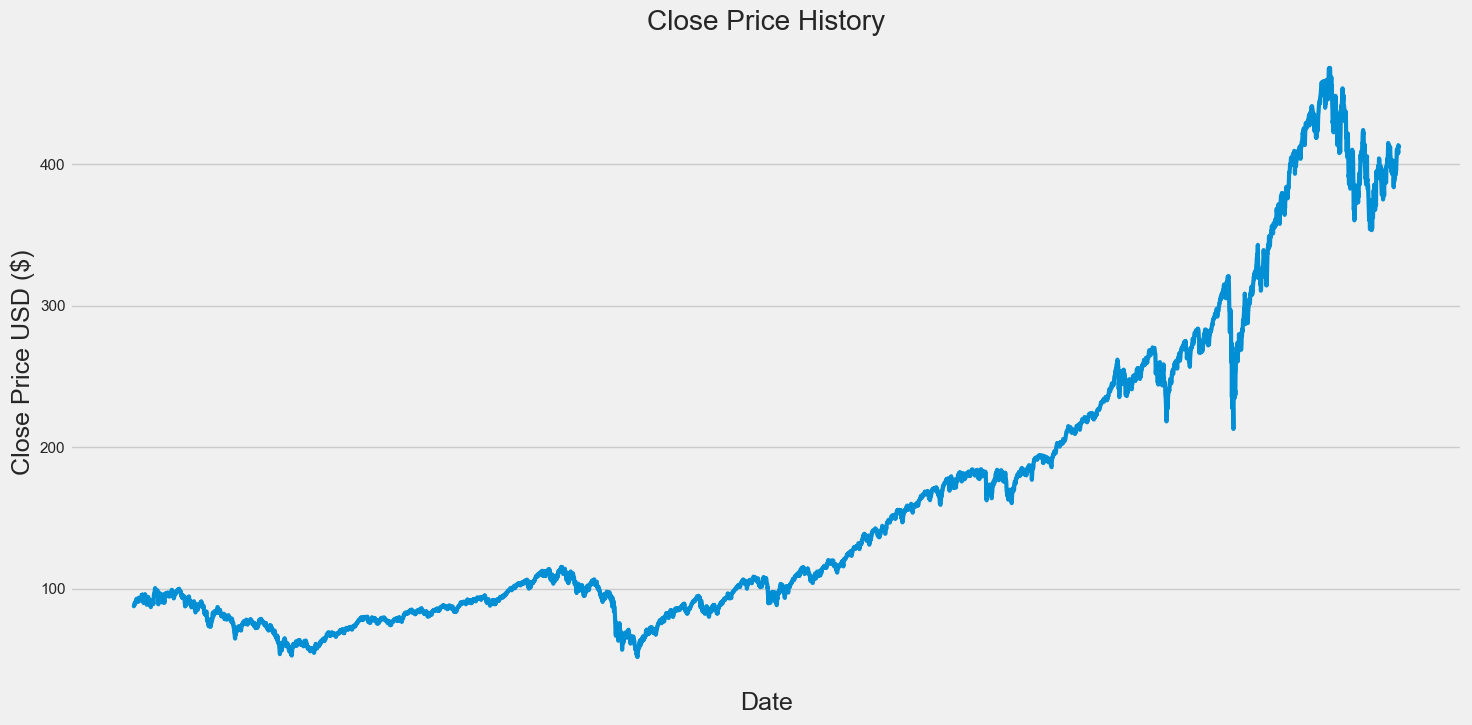

In [55]:
#plot the stock price graph
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(stock_cleaned_data['adjclose'], linewidth=3)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.xticks([])
plt.show()

# Section 3 - Exploratory Data Analysis

<Axes: xlabel='volume', ylabel='Count'>

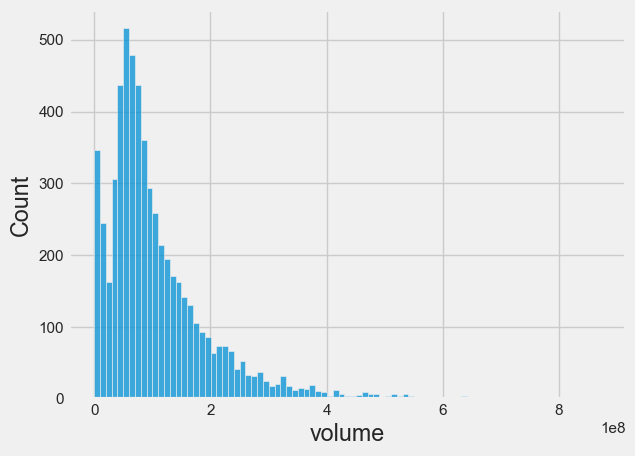

In [113]:
sns.histplot(x='volume', data=stock_cleaned_data)

Correlation Coefficient: -0.13274584140618198


Text(16.33333333333333, 0.5, 'Volume')

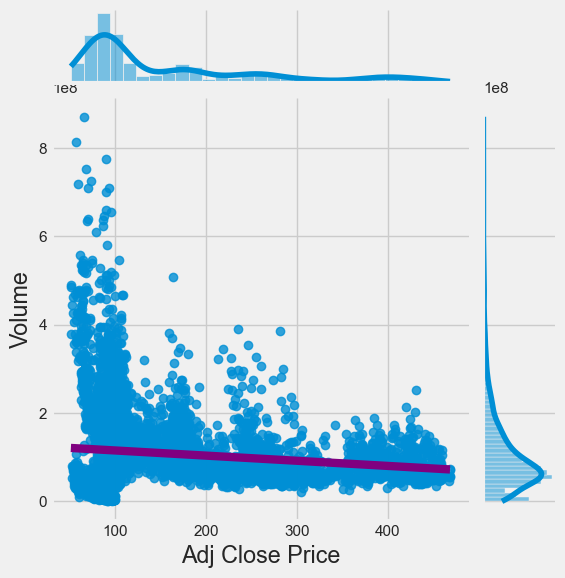

In [107]:
corr_coeff = stock_cleaned_data['volume'].corr(stock_cleaned_data['adjclose'])
print('Correlation Coefficient:', corr_coeff)

sns.jointplot(x='adjclose', y='volume', data=stock_cleaned_data, kind='reg', 
              line_kws={'color': 'purple'})

plt.xlabel('Adj Close Price')
plt.ylabel('Volume')

Correlation Coefficient: 0.20952449585622854


Text(16.33333333333333, 0.5, 'Volume')

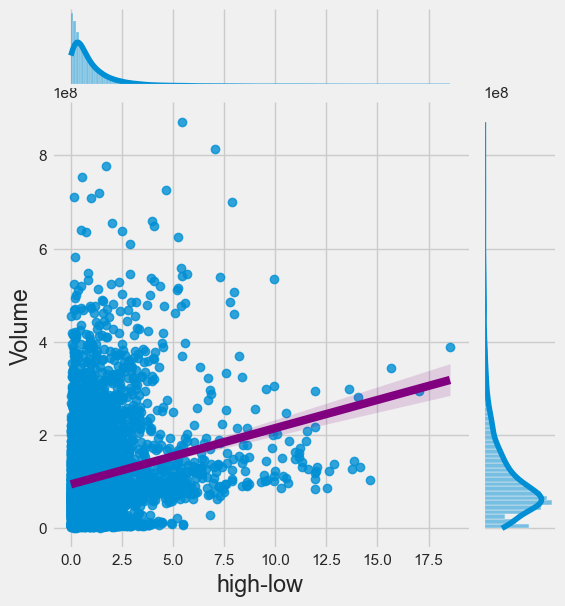

In [111]:
corr_coeff = stock_cleaned_data['volume'].corr(stock_cleaned_data['high'] - stock_cleaned_data['close'])
print('Correlation Coefficient:', corr_coeff)

sns.jointplot(x=stock_cleaned_data['high'] - stock_cleaned_data['close'], y='volume', data=stock_cleaned_data, kind='reg', 
              line_kws={'color': 'purple'})

plt.xlabel('high-low')
plt.ylabel('Volume')

In [ ]:
import plotly.graph_objects as go
from datetime import datetime

fig = go.Figure(data=[go.Candlestick(x=stock_cleaned_data.index,
                open=stock_cleaned_data['open'],
                high=stock_cleaned_data['high'],
                low=stock_cleaned_data['low'],
                close=stock_cleaned_data['close'])])

fig.show()

# SECTION 4 - RMSE AND MAPE

In [56]:
def calculate_rmse(y_true, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE)  
    """ 
    return np.sqrt(mean_squared_error(y_true, y_pred))

### The effectiveness of prediction method is measured in terms of the Mean Absolute Percentage Error (MAPE) and RMSE
def calculate_mape(y_true, y_pred): 
    """
    Calculate the Mean Absolute Percentage Error (MAPE) %
    """
    y_pred, y_true = np.array(y_pred), np.array(y_true)    
    mape = np.mean(np.abs((y_true-y_pred) / y_true))*100    
    return mape

# SECTION 5 - #1 NAIVE

In [60]:
data=stock_cleaned_data.filter(['close'])
dataset=data.values
training_data_len = math.ceil(len(dataset)*.8)
test_data_len=len(dataset) - train_data_len
print("testing data size:", test_data_len)

test_data = dataset[-test_data_len:, : ]

testing data size: 1180


In [61]:
initial_forecast = dataset[training_data_len-1]
naive_pred = [initial_forecast]

for i in range(0, test_data_len-1):
    naive_pred.append(test_data[i])

print("RMSE\t:", calculate_rmse(test_data,naive_pred))
print("MAPE\t:", calculate_mape(test_data,naive_pred))

RMSE	: 4.617054503483318
MAPE	: 0.9199074740856902


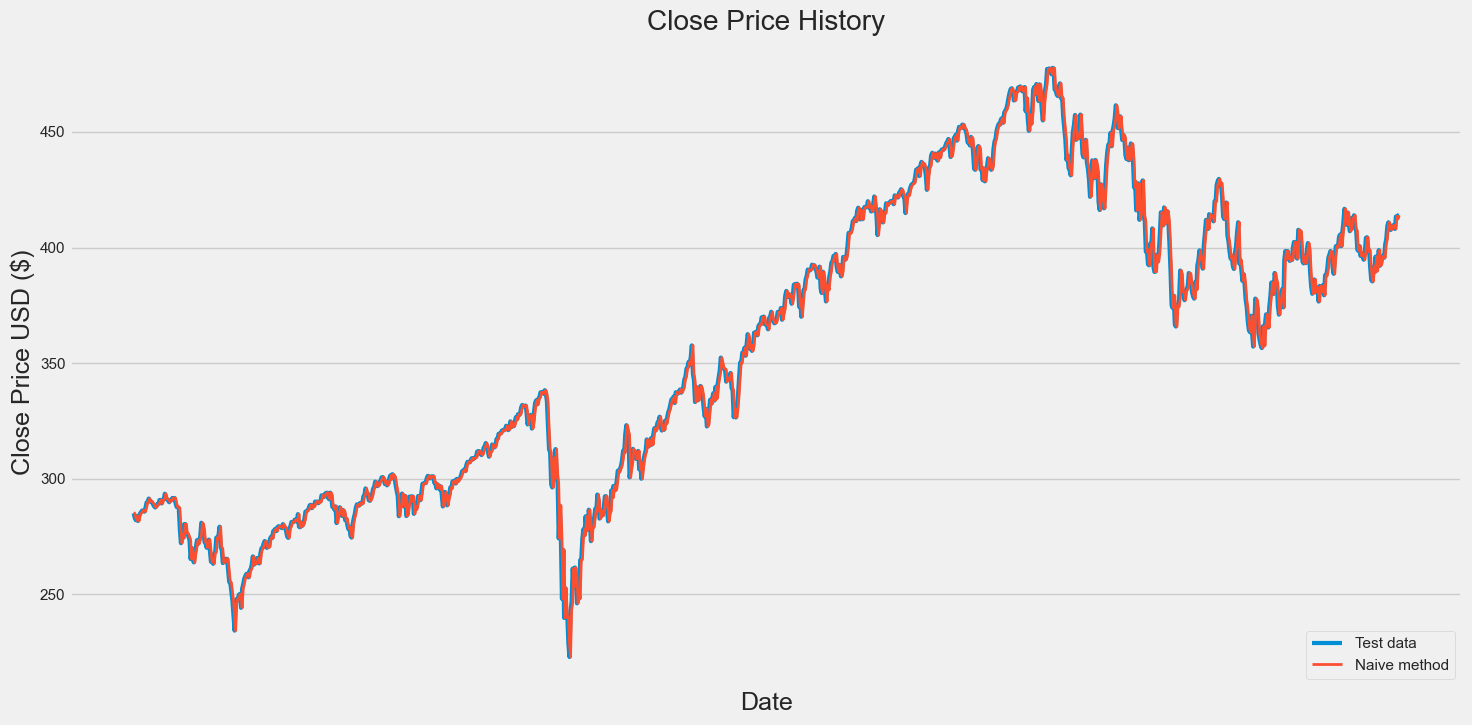

In [62]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(test_data, linewidth=3)
plt.plot(naive_pred, linewidth=2)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.legend(['Test data', 'Naive method'],loc='lower right')
plt.xticks([])
plt.show()

# SECTION 6 - #2 Moving Average

In [63]:
data=stock_cleaned_data.filter(['close'])
dataset=data.values

test_data_len=len(dataset)-math.ceil(len(dataset)*.8)
print("testing data size:", test_data_len)

testing data size: 1180


In [64]:
def MA(dataset, test_length, window_size):
    MA_pred = []
    test_data = dataset[-test_length:, : ]
    
    for i in range(test_length, 0, -1):
        MA_pred.append(np.mean(dataset[(-i- window_size):(-i-1)]))
    
    return MA_pred

In [65]:
grid = [5, 10, 50 ,100 ,200]

In [66]:
for windowsize in grid:
    print(f"RMSE of window size {windowsize}\t:", calculate_rmse(test_data, MA(dataset, test_data_len, windowsize)))

RMSE of window size 5	: 7.367180701845453
RMSE of window size 10	: 9.079042334419993
RMSE of window size 50	: 16.94923398833353
RMSE of window size 100	: 21.63192588648995
RMSE of window size 200	: 30.816086051763246


**Plot of different MA window sizes**

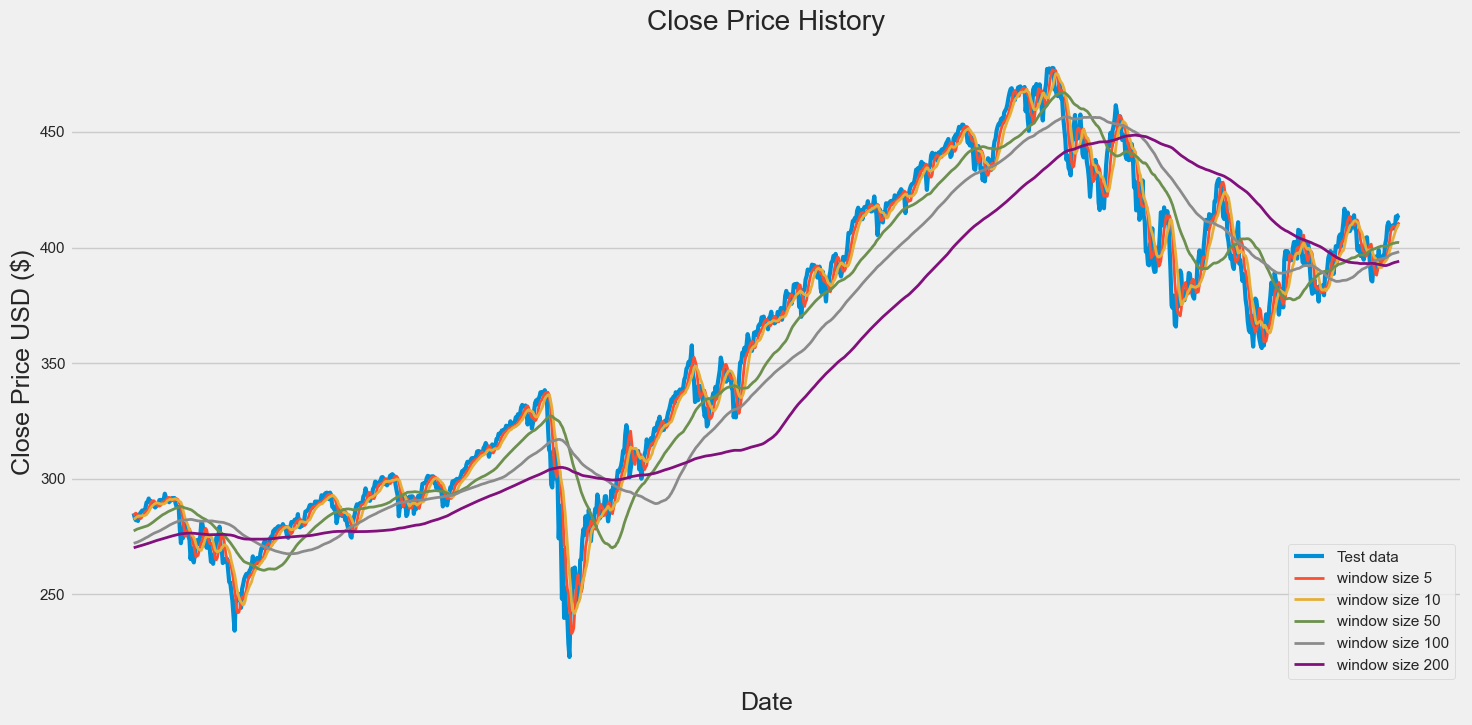

In [67]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(test_data, linewidth=3)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
legend = ['Test data']

for windowsize in grid:
    plt.plot(MA(dataset,test_data_len, windowsize), linewidth=2)
    legend.append(f"window size {windowsize}")
plt.legend(legend,loc='lower right')
plt.xticks([])
plt.show()

# SECTION 7 - #3 EXPONENTIAL SMOOTHING

**Exponential smoothing without trend**

In [68]:
data=stock_cleaned_data.filter(['close'])
dataset=data.values
train_data_len = math.ceil(len(dataset)*.8)
test_data_len=len(dataset) - train_data_len
print("testing data size:", test_data_len)
train_data = dataset[:train_data_len, :]
test_data = dataset[-test_data_len:, : ]

testing data size: 1180


In [69]:
alpha_grid = np.linspace(0,1,1001)

In [70]:
minimal = 100
saved_alpha = 0
for alpha in alpha_grid:
    ES_pred = [float(train_data[0])]

    for i in range(1, train_data_len):
        ES_pred.append(float(alpha * train_data[i-1] + (1 - alpha) * ES_pred[i-1]))
    
    if minimal > calculate_rmse(train_data, ES_pred):
        minimal = calculate_rmse(train_data, ES_pred)
        saved_alpha = alpha
        saved_ES_pred = ES_pred
        
print("optimal alpha\t:", saved_alpha)
print("training RMSE\t:", minimal)

optimal alpha	: 0.9420000000000001
training RMSE	: 1.5460774333219414


In [71]:
alpha = saved_alpha

ES_test_pred = [float(test_data[0])]

for i in range(1, test_data_len):
    ES_test_pred.append(float(alpha * test_data[i-1] + (1 - alpha) * ES_test_pred[i-1]))
    
print("testing RMSE\t:", calculate_rmse(test_data, ES_test_pred))

testing RMSE	: 4.598907266468322


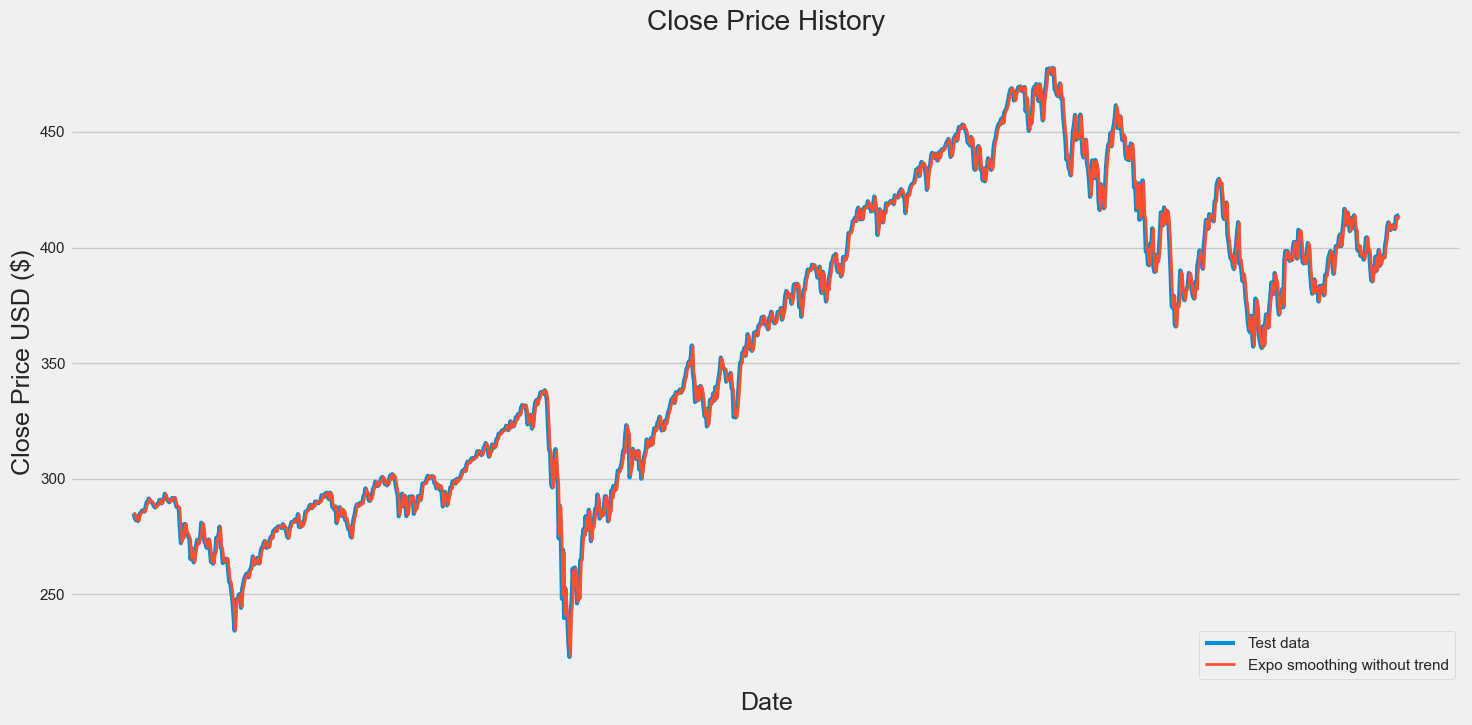

In [72]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(test_data, linewidth=3)
plt.plot(ES_test_pred, linewidth=2)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.legend(['Test data', 'Expo smoothing without trend'],loc='lower right')
plt.xticks([])
plt.show()

**Exponential smoothing with trend**

In [75]:
alpha_grid = np.linspace(0,1,101)
beta_grid = np.linspace(0,1,101)

In [ ]:
minimal = 100
saved_alpha = 0
saved_beta = 0

for alpha in alpha_grid:
    for beta in beta_grid:
        B = [float(train_data[0])]
        T = [float(train_data[1] - train_data[0])]
        ES_trend_pred = [float(train_data[0])]

        for i in range(1, train_data_len):
            B.append(float(alpha * train_data[i-1] + (1 - alpha) * ES_trend_pred[i-1]))
            T.append(float(beta * float(B[i] - B[i-1]) + (1 - beta) * float(T[i-1])))
            ES_trend_pred.append(float(B[i] + T[i]))
        
        if minimal > calculate_rmse(train_data, ES_trend_pred):
            minimal = calculate_rmse(train_data, ES_trend_pred)
            saved_alpha = alpha
            saved_beta = beta
            saved_ES_trend_pred = ES_trend_pred
            
print("Optimal alpha\t:", saved_alpha)
print("Optimal beta\t:", saved_beta)
print("training RMSE\t:", minimal)

In [ ]:
alpha = saved_alpha
beta = saved_beta

B = [float(test_data[0])]
T = [float(test_data[1] - test_data[0])]
ES_trend_test_pred = [float(test_data[0])]

for i in range(1, test_data_len):
    B.append(float(alpha * test_data[i-1] + (1 - alpha) * ES_trend_test_pred[i-1]))
    T.append(float(beta * float(B[i] - B[i-1]) + (1 - beta) * float(T[i-1])))
    ES_trend_test_pred.append(float(B[i] + T[i]))

print("testing RMSE\t:", calculate_rmse(test_data, ES_trend_test_pred))

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(test_data, linewidth=3)
plt.plot(ES_trend_test_pred, linewidth=2)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.legend(['Test data', 'Expo smoothing with trend'],loc='lower right')
plt.xticks([])
plt.show()

# SECTION 8 - #4 LSTM

In [91]:
data=stock_cleaned_data.filter(['close'])
dataset=data.values
training_data_len=math.ceil(len(dataset)*.8)
training_data_len

4723

In [92]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)
scaled_data

array([[0.16467895],
       [0.16231373],
       [0.16452637],
       ...,
       [0.84069824],
       [0.84431152],
       [0.8449707 ]])

In [93]:
train_data=scaled_data[0:training_data_len, : ]
x_train= []
y_train= []

for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])  

In [94]:
x_train,y_train=np.array(x_train),np.array(y_train)

In [95]:
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(4663, 60, 1)

In [96]:
#Build the LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [97]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [ ]:
model.fit(x_train,y_train,batch_size=1,epochs=1)

In [ ]:
#Create the testing dataset
test_data=scaled_data[training_data_len - 60: , :]
x_test=[]
y_test=dataset[training_data_len:, : ]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [ ]:
x_test=np.array(x_test)

In [ ]:
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [ ]:
predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)

In [ ]:
calculate_rmse(y_test,predictions)

In [ ]:
calculate_mape(y_test,predictions)

In [ ]:
train=data[:training_data_len]
valid=data[training_data_len:]
valid['Predictions']=predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close','Predictions']])
plt.legend(['Train','Val','Predictions'],loc='lower right')
plt.show

**Improve model**